## Federated Newton Learn
In this section we present the algorithm named Federated Newton Learning (FEDNL) introduced in [2]. The following table contains information regarding the convergence of different FedNL flavours in particular the error column contains $\mathcal{L}(x_{50})-\mathcal{L}(x^*)$.

| Flavour | tol | iteration | Error |
| :--- | --- | --- | --- |
| Vanilla Newton | 1e-4 | 4 | 0.0 |
| Rank 1 Compression | 1e-4 | 10 |1.4901161193847656e-07|
| Rank 1 Compression Diagonal Regularisation $\newline$ Identity Initial Hessian | 1e-4 | >50 | 0.1078076362609863|
| Rank 1 Compression Diagonal Regularisation $\newline$ Null Initial Hessian | 1e-4 | >50 |8.705258369445801e-05|

In [1]:
from ipyparallel import Client
c = Client()
c.ids

[0, 1]

### Vanilla Newton
First we reimplement the vanilla Newton method in the framework of FEDNL.

In [8]:
%%px
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl

comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]

tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
#Defining the Loss Function
def LossSerial(x):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0]) + lam*tf.norm(x)**2

    return S
#Defining the Loss Function
def Loss(x,comm):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0]) + lam*tf.norm(x)**2
    return S
################! Setting Of The Solver!##################
itmax = 50
tol = 1e-4;
step_size=1;
###########################################################
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))

Res = [];

H = Hessian(Loss,x);
H.shift(x)#,start=0*np.identity(x.numpy().shape[0])) #We initialize the shifter
#We now collect and average the loc Hessians in the master node (rk 0)
Hs = H.comm.gather(H.memH, root=0);
if H.comm.Get_rank()==0:
    Hm = (1/len(Hs))*np.sum(Hs,0);
else:
    Hm = None
print("The master Hessian has been initialised")
for it in tqdm(range(itmax)):
    # Obtaining the compression of the difference between local mat
    # and next local mat.
    U,sigma,Vt,ell = H.shift(x,{"comp":MatSVDCompDiag,"rk":119,"type":"mat"});
    shift = Vt.transpose()@np.diag(sigma)@U.transpose();
    #print("Updating local Hessian")
    H.memH = H.memH+step_size*shift;
    grad = H.grad().numpy();
    #Now we update the master Hessian and perform the Newton method step
    Shifts = H.comm.gather(shift, root=0);
    Grads = H.comm.gather(grad, root=0);
    Ells = H.comm.gather(ell, root=0);
    if H.comm.Get_rank() == 0:
        #print("Computing the avarage of the local shifts and grad ...")
        Shift = (1/len(Shifts))*np.sum(Shifts,0);
        Grad = (1/len(Grads))*np.sum(Grads,0);
        Ell = (1/len(Ells))*np.sum(Ells,0);
        res = np.linalg.norm(Grad);
        Res = Res + [res]
        #print("Computing the master Hessian ...")
        Hm = Hm + step_size*Shift;
        #print("Searching new search direction ...")
        A = Hm; #A = Hm + Ell*np.identity(Hm.shape[0]);
        q = np.linalg.solve(A,Grad);
        #print("Found search dir, ",q);
        if it%25 == 0:
            print("(FedNL) [Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(Grad)));
        x = x - tf.Variable(q,dtype=np.float32);
        x =  tf.Variable(x)
    else:
        res = None
    #Distributing the search direction
    x = H.comm.bcast(x,root=0)
    res = H.comm.bcast(res,root=0)
    if res<tol:
            break
LossStar =  0.33691510558128357;
print("Lost funciton at this iteration {}, gradient norm {} and error {}.".format(LossSerial(x),np.linalg.norm(grad),abs(LossSerial(x)-LossStar)))

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1]   8%|▊         | 4/50 [00:18<03:30,  4.57s/it]


[stderr:0]   8%|▊         | 4/50 [00:18<03:30,  4.57s/it]


[stdout:1] The master Hessian has been initialised
Lost funciton at this iteration 0.33691510558128357, gradient norm 0.020152254030108452 and error 0.0.


[stdout:0] The master Hessian has been initialised
(FedNL) [Iteration. 0] Lost funciton at this iteration 1.2675940990447998  and gradient norm 1.388305902481079
Lost funciton at this iteration 0.33691510558128357, gradient norm 0.02014993503689766 and error 0.0.


Text(0.5, 1.0, 'Residual Decay')

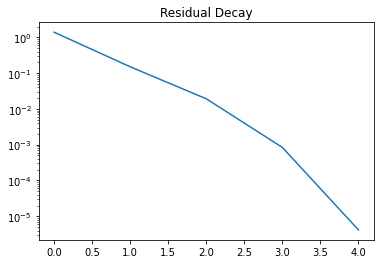

In [10]:
import matplotlib.pyplot as plt
Rs = c[:]["Res"][0]
plt.semilogy(range(len(Rs)),Rs)
plt.title("Residual Decay")

### FEDNL Rank 1 Compression

In [4]:
%%px
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl

comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]

tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
#Defining the Loss Function
def LossSerial(x):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0]) + lam*tf.norm(x)**2

    return S
#Defining the Loss Function
def Loss(x,comm):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0]) + lam*tf.norm(x)**2
    return S
################! Setting Of The Solver!##################
itmax = 50
tol = 1e-4;
step_size=1;
###########################################################
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))

Res = [];

H = Hessian(Loss,x);
H.shift(x)#,start=0*np.identity(x.numpy().shape[0])) #We initialize the shifter
#We now collect and average the loc Hessians in the master node (rk 0)
Hs = H.comm.gather(H.memH, root=0);
if H.comm.Get_rank()==0:
    Hm = (1/len(Hs))*np.sum(Hs,0);
else:
    Hm = None
print("The master Hessian has been initialised")
for it in tqdm(range(itmax)):
    # Obtaining the compression of the difference between local mat
    # and next local mat.
    U,sigma,Vt,ell = H.shift(x,{"comp":MatSVDCompDiag,"rk":1,"type":"mat"});
    shift = Vt.transpose()@np.diag(sigma)@U.transpose();
    #print("Updating local Hessian")
    H.memH = H.memH+step_size*shift;
    grad = H.grad().numpy();
    #Now we update the master Hessian and perform the Newton method step
    Shifts = H.comm.gather(shift, root=0);
    Grads = H.comm.gather(grad, root=0);
    Ells = H.comm.gather(ell, root=0);
    if H.comm.Get_rank() == 0:
        #print("Computing the avarage of the local shifts and grad ...")
        Shift = (1/len(Shifts))*np.sum(Shifts,0);
        Grad = (1/len(Grads))*np.sum(Grads,0);
        Ell = (1/len(Ells))*np.sum(Ells,0);
        res = np.linalg.norm(Grad);
        Res = Res + [res];
        #print("Computing the master Hessian ...")
        Hm = Hm + step_size*Shift;
        #print("Searching new search direction ...")
        A = Hm; #A = Hm + Ell*np.identity(Hm.shape[0]);
        q = np.linalg.solve(A,Grad);
        #print("Found search dir, ",q);
        if it%25 == 0:
            print("(FedNL) [Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(Grad)));
        x = x - tf.Variable(q,dtype=np.float32);
        x =  tf.Variable(x)
    else:
        res = None
    #Distributing the search direction
    x = H.comm.bcast(x,root=0)
    res = H.comm.bcast(res,root=0)
    if res<tol:
            break
LossStar =  0.33691510558128357;
print("Lost funciton at this iteration {}, gradient norm {} and error {}.".format(LossSerial(x),np.linalg.norm(grad),abs(LossSerial(x)-LossStar)))

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1]  20%|██        | 10/50 [00:39<02:37,  3.95s/it]


[stderr:0]  20%|██        | 10/50 [00:39<02:37,  3.95s/it]


[stdout:0] The master Hessian has been initialised
(FedNL) [Iteration. 0] Lost funciton at this iteration 1.2675940990447998  and gradient norm 1.388305902481079
Lost funciton at this iteration 0.3369152545928955, gradient norm 0.020166713744401932 and error 1.4901161193847656e-07.


[stdout:1] The master Hessian has been initialised
Lost funciton at this iteration 0.3369152545928955, gradient norm 0.02014790289103985 and error 1.4901161193847656e-07.


Text(0.5, 1.0, 'Residual Decay')

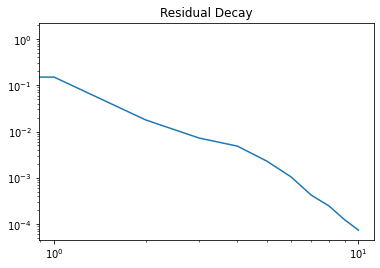

In [6]:
import matplotlib.pyplot as plt
Rs = c[:]["Res"][0]
plt.loglog(range(len(Rs)),Rs)
plt.title("Residual Decay")

### FEDNL With Diagonal Regularisation And Different Initial Hessian

In [5]:
%%px
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl

comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]

tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
#Defining the Loss Function
def LossSerial(x):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0]) + lam*tf.norm(x)**2

    return S
#Defining the Loss Function
def Loss(x,comm):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0]) + lam*tf.norm(x)**2
    return S
################! Setting Of The Solver!##################
itmax = 50
tol = 1e-4;
step_size=1;
###########################################################
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))

H = Hessian(Loss,x);
H.shift(x,start=np.eye(x.numpy().shape[0])) #We initialize the shifter
#We now collect and average the loc Hessians in the master node (rk 0)
Hs = H.comm.gather(H.memH, root=0);
if H.comm.Get_rank()==0:
    Hm = (1/len(Hs))*np.sum(Hs,0);
else:
    Hm = None
print("The master Hessian has been initialised")
for it in tqdm(range(itmax)):
    # Obtaining the compression of the difference between local mat
    # and next local mat.
    U,sigma,Vt,ell = H.shift(x,{"comp":MatSVDCompDiag,"rk":1,"type":"mat"});
    shift = Vt.transpose()@np.diag(sigma)@U.transpose();
    #print("Updating local Hessian")
    H.memH = H.memH+step_size*shift;
    grad = H.grad().numpy();
    #Now we update the master Hessian and perform the Newton method step
    Shifts = H.comm.gather(shift, root=0);
    Grads = H.comm.gather(grad, root=0);
    Ells = H.comm.gather(ell, root=0);
    if H.comm.Get_rank() == 0:
        #print("Computing the avarage of the local shifts and grad ...")
        Shift = (1/len(Shifts))*np.sum(Shifts,0);
        Grad = (1/len(Grads))*np.sum(Grads,0);
        Ell = (1/len(Ells))*np.sum(Ells,0);
        res = np.linalg.norm(Grad);
        #print("Computing the master Hessian ...")
        Hm = Hm + step_size*Shift;
        #print("Searching new search direction ...")
        A = Hm + Ell*np.identity(Hm.shape[0]);
        q = np.linalg.solve(A,Grad);
        #print("Found search dir, ",q);
        if it%25 == 0:
            print("(FedNL) [Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(Grad)));
        x = x - tf.Variable(q,dtype=np.float32);
        x =  tf.Variable(x)
    else:
        res = None
    #Distributing the search direction
    x = H.comm.bcast(x,root=0)
    res = H.comm.bcast(res,root=0)
    if res<tol:
            break
LossStar =  0.33691510558128357;
print("Lost funciton at this iteration {}, gradient norm {} and error {}.".format(LossSerial(x),np.linalg.norm(grad),abs(LossSerial(x)-LossStar)))

[stderr:1] 100%|██████████| 50/50 [02:58<00:00,  3.58s/it]


[stderr:0] 100%|██████████| 50/50 [02:58<00:00,  3.58s/it]


[stdout:1] The master Hessian has been initialised
Lost funciton at this iteration 0.4447227418422699, gradient norm 0.1290498971939087 and error 0.10780763626098633.


[stdout:0] The master Hessian has been initialised
(FedNL) [Iteration. 0] Lost funciton at this iteration 1.2675940990447998  and gradient norm 1.388305902481079
(FedNL) [Iteration. 25] Lost funciton at this iteration 0.4930209219455719  and gradient norm 0.16765998303890228
Lost funciton at this iteration 0.4447227418422699, gradient norm 0.10724713653326035 and error 0.10780763626098633.


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]